## SFC Meteorology Obs from:
** - 2018/2019 M2 (BSITAEPR-2A) **   
*** - 2011-2019 M2 (BSM-2A : argo feed) ***   
*** - 20??-2019 M2 (BSM-2A : final data) ***

__pyversion__==3.6   
__author__==S.Bell

In [1]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2019-10-07 10:56:57.005211


### connecting to erddap and retrieving and basic information

In [2]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

In [3]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='bsitaepr2a_met'))

In [4]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 2 tabledap, 0 griddap, and 0 wms endpoints.'

In [5]:
datasets = df['Dataset ID'].values
print(datasets)

['erddap_18bsitaepr2a_met' 'erddap_19bsitaepr2a_met']


In [6]:
variables = [e.get_var_by_attr(dataset_id=dataset, standard_name=lambda v: v is not None) for dataset in datasets]
print(variables)

[['air_pressure', 'relative_humidity', 'wind_from_direction', 'time', 'latitude', 'longitude', 'eastward_wind', 'wind_speed', 'air_temperature', 'northward_wind'], ['air_pressure', 'relative_humidity', 'time', 'longitude', 'latitude', 'eastward_wind', 'air_temperature', 'northward_wind']]


### getting Peggy Buoy (BSM-2A) Data

In [7]:
wdf = pd.read_csv('http://pavlof.pmel.noaa.gov/bell/ArgosMooring/data/TotalArgosMessage_28882.csv',
                  parse_dates=True,index_col='sampletime')

adf = pd.read_csv('/Users/bell/scratch/bsm2a_wpak.csv',
                 parse_dates=True,index_col='date')

In [8]:
wdf = wdf.resample('1H').mean()
adf = adf.resample('1H').mean()

adf_doy = adf.index.dayofyear+adf.index.hour/24

### retrieving erddap and plotting data

In [9]:
constraints = {
    'time>=': '2017-04-25T00:00:00Z',
    'time<=': str(datetime.datetime.today()),
}

variables = [
# 'wind_from_direction', 
 'air_temperature',
 'relative_humidity',
 'northward_wind', 
 'eastward_wind', 
# 'wind_speed', 
 'latitude',
 'longitude',
 'time'
]

variable_dic={}

for index,row in df.iterrows():
    info_url = e.get_info_url(dataset_id=row['Dataset ID'], response='csv')
    info = pd.read_csv(info_url)

    #print(info.head())
    print('Variables in {}:'.format(row['Dataset ID']))
    print(','.join(info.loc[info['Row Type'] == 'variable', 'Variable Name']))

    variable_dic.update({row['Dataset ID']:list(info.loc[info['Row Type'] == 'variable', 'Variable Name'])})
    

Variables in erddap_18bsitaepr2a_met:
timeseries_id,time,wind_speed,northward_wind,latitude,longitude,air_pressure,relative_humidity,air_temperature,wind_from_direction,eastward_wind
Variables in erddap_19bsitaepr2a_met:
timeseries_id,latitude,longitude,time,northward_wind,air_pressure,relative_humidity,air_temperature,eastward_wind


In [10]:
from requests.exceptions import HTTPError

dfs = {}
for index,row in df.iterrows():
    if row['Dataset ID'] in ['erddap_19bsitaepr2a_met','erddap_18bsitaepr2a_met']:
        print(row['Dataset ID'])
        try:
            e = ERDDAP(server=server_url,
                protocol='tabledap',
                response='csv',
            )
            e.dataset_id=row['Dataset ID']
            e.constraints=constraints
            if row['Dataset ID'] in ['erddap_19bsitaepr2a_met','erddap_18bsitaepr2a_met']:
                e.variables=variables + ['air_pressure']
        except HTTPError:
            print('Failed to generate url {}'.format(row['Dataset ID']))
            continue
        dfs.update({row['Dataset ID']: e.to_pandas(
                                index_col='time (UTC)',
                                parse_dates=True,
                                skiprows=(1,)  # units information can be dropped.
                                )})
    

erddap_18bsitaepr2a_met
erddap_19bsitaepr2a_met


In [11]:
df=dfs['erddap_19bsitaepr2a_met']
df.columns

Index(['air_temperature', 'relative_humidity', 'northward_wind',
       'eastward_wind', 'latitude (degrees_north)', 'longitude (degrees_east)',
       'air_pressure'],
      dtype='object')

### Take care of any preliminary QC

In [12]:
#calculate windspeed and direction
for ds, df in dfs.items():
    try:
        df['wind_speed (m s-1)']=np.sqrt(df['northward_wind']**2 + df['eastward_wind']**2)
        df['wind_from_direction (degrees true)'] = 270-np.rad2deg(np.arctan2(df['northward_wind'],
                                                                     df['eastward_wind']))

        df['wind_from_direction (degrees true)'][df['wind_from_direction (degrees true)']>360] = df['wind_from_direction (degrees true)'][df['wind_from_direction (degrees true)']>360]-360
    except:
        df['wind_speed (m s-1)']=np.sqrt(df['northward_wind (m s-1)']**2 + df['eastward_wind (m s-1)']**2)
        df['wind_from_direction (degrees true)'] = 270-np.rad2deg(np.arctan2(df['northward_wind (m s-1)'],
                                                                     df['eastward_wind (m s-1)']))

        df['wind_from_direction (degrees true)'][df['wind_from_direction (degrees true)']>360] = df['wind_from_direction (degrees true)'][df['wind_from_direction (degrees true)']>360]-360
        

In [16]:
#eliminate unlikely wind and pressure extremes
for ds, df in dfs.items():
    df['wind_speed (m s-1)'][df['wind_speed (m s-1)']>100] = np.nan
    try:
        df['air_pressure'][df['air_pressure']<940] = np.nan
    except:
        df['air_pressure (mbar)'][df['air_pressure (mbar)']<940] = np.nan
    try:
        df['air_temperature'][df['air_temperature']>50] = np.nan
    except:
        df['air_temperature (degree_C)'][df['air_temperature (degree_C)']>=50] = np.nan

#Arbitrary QC points based on evaluating plot / local characteristics and not broad science boundaries
wdf.WS[wdf.WS>25] = np.nan
wdf.RH[wdf.RH<25] = np.nan
wdf.BP[wdf.BP<975] = np.nan

### Plot

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean
### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

NameError: name 'adf_doy' is not defined

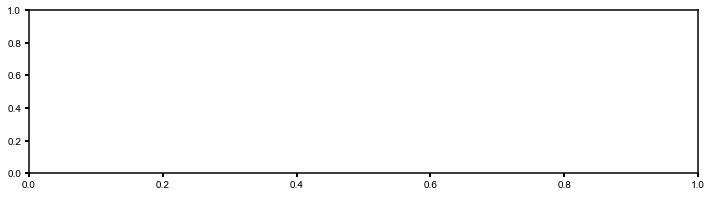

In [4]:
fig, ax = plt.subplots(figsize=(12,3))
plt.plot(adf_doy.values,adf.AT,'grey',alpha=.75,linewidth=.75)

for ds, df in dfs.items():
    try:
        plt.plot((df.index.dayofyear+df.index.hour/24+df.index.minute/(24*60)).values,df['air_temperature'],'red',linewidth=.75)
        plt.ylabel('Temperature (degC)')
    except:
        plt.plot((df.index.dayofyear+df.index.hour/24+df.index.minute/(24*60)).values,df['air_temperature (degree_C)'],
                 'grey',alpha=.75,linewidth=.75)
    finally:
        print(f"Error in {ds}")

plt.legend(['Peggy (2010-2017)','Prawler (2018)','Prawler (2019)'])
ax.xaxis.set_major_locator(DayLocator(bymonthday=[1]))
ax.xaxis.set_minor_locator(DayLocator(range(0,28,15)))
ax.xaxis.set_minor_formatter(DateFormatter('%b'))
ax.xaxis.set_major_formatter(DateFormatter(''))

## Year over Year integrated heat (with prawler data when necessary)

In [5]:
ih_file = '/Users/bell/in_and_outbox/Ongoing_Analysis/M2_IntegratedTemp/year_over_year/BS_ReportCard_M2_depthave_1995-2019_6hr-gdm.xlsx'
df_ih = pd.read_excel(ih_file,sheet_name='by year',parse_dates=True,index_col='6hourly date')

df_ih = df_ih.resample('1D').mean()

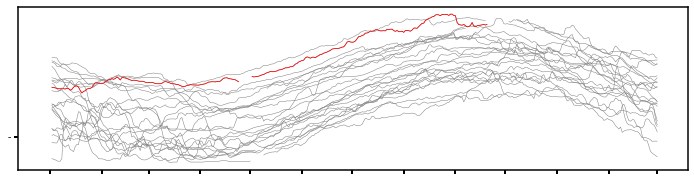

In [6]:
fig, ax = plt.subplots(figsize=(12,3))
for column in df_ih.columns:
    if not column in ['Unnamed: 26']:
        plt.plot(df_ih.index.dayofyear,df_ih[column],'grey','-',linewidth='.5')
    if column in [2019]:
        plt.plot(df_ih.index.dayofyear,df_ih[column],'red','-',linewidth='.75')
    plt.xticks([1,32,60,91,121,152,182,213,244,274,305,336,365],[],minor=False)



(106, 305)

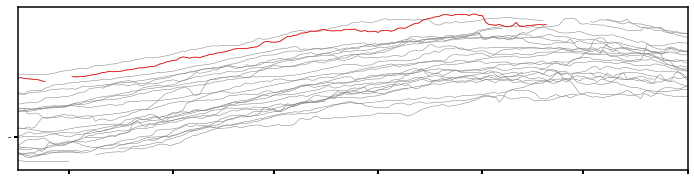

In [149]:
fig, ax = plt.subplots(figsize=(12,3))
for column in df_ih.columns:
    if not column in ['Unnamed: 26']:
        plt.plot(df_ih.index.dayofyear,df_ih[column],'grey','-',linewidth='.5')
    if column in [2019]:
        plt.plot(df_ih.index.dayofyear,df_ih[column],'red','-',linewidth='.75')
    plt.xticks([1,32,60,91,121,152,182,213,244,274,305,336,365],[],minor=False)

ax.set_xlim([106,305])

In [7]:
### Long timeseries

In [8]:
df_ih

,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
6hourly date,,,,,,,,,,,,,,,,,,,,,
1995-01-02,NaN,NaN,2.110507,0.545587,2.213517,-1.484912,5.117642,1.961983,4.747611,3.592095,...,NaN,0.068416,2.130605,-0.380194,NaN,5.319743,3.983223,5.019351,3.107104,3.321741
1995-01-03,NaN,NaN,1.947902,0.385821,2.156696,-1.533720,5.080926,1.992503,4.625456,3.555973,...,NaN,0.138621,2.181520,-0.424146,NaN,5.324649,3.934784,4.986983,3.068393,3.315131
1995-01-04,NaN,NaN,1.794726,0.453047,2.087220,-1.572571,5.021628,2.026885,4.488530,3.402524,...,NaN,0.052325,2.042061,-0.430428,NaN,5.315726,3.923760,4.915291,3.051796,3.284201
1995-01-05,NaN,NaN,1.616507,0.582664,2.067547,-1.632868,4.933047,2.129389,4.282554,3.231463,...,NaN,0.029873,1.907514,-0.436893,NaN,5.317091,3.836716,4.748770,3.024734,3.257797
1995-01-06,NaN,NaN,1.470774,0.573723,2.143733,-1.676284,4.875314,2.310669,4.079250,3.113564,...,NaN,-0.042248,1.870601,-0.212418,NaN,5.092061,3.806243,4.717980,3.041643,3.229137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995-12-27,NaN,2.260324,1.730848,2.563645,-1.016724,5.156797,1.955061,4.957078,3.102760,3.969139,...,0.959110,2.801865,-0.216234,NaN,5.531152,4.041720,5.112713,3.316473,3.634236,NaN
1995-12-28,NaN,2.225253,1.666875,2.592223,-1.123705,5.139307,1.948287,4.848274,3.420152,3.863372,...,0.846104,2.680878,-0.329580,NaN,5.582595,4.065372,5.015355,3.286405,3.528086,NaN
1995-12-29,NaN,2.232689,1.257653,2.603791,-1.204991,5.134818,1.811814,4.806740,3.653611,3.778284,...,0.776967,2.572003,-0.311226,NaN,5.545676,4.023595,4.931176,3.220572,3.412338,NaN


In [57]:
df_ih = pd.read_excel(ih_file,sheet_name='by year (2)',parse_dates=True,index_col='6hourly date')


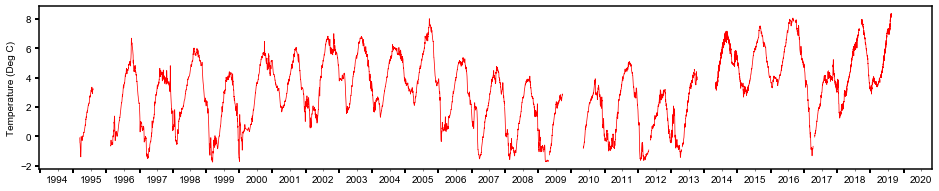

In [94]:
fig, ax = plt.subplots(figsize=(16,3))
for column in df_ih.columns:
    if column not in ['doy','Unnamed: 27']:
        plt.plot(df_ih.index + datetime.timedelta(days=(int(column)-1995)*365),df_ih[column],'red',linewidth='.75')
        
ax.set_ylabel('Temperature (Deg C)')
ax.xaxis.set_major_locator(MonthLocator(bymonth=1, bymonthday=1))
ax.xaxis.set_minor_locator(MonthLocator(bymonth=7, bymonthday=15))
ax.xaxis.set_major_formatter(DateFormatter(''))
ax.xaxis.set_minor_formatter(DateFormatter('%Y'))
